## XGBoost

In [1]:
# libraries

import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [2]:
# loading test and train datasets 

### change this:
test_path = 'C:/Users/endzi/Downloads/RR Project/RR-Project-Stock-Price-Forecasting-in-Presence-of-Covid-19/Data/Data train-test/test.csv'
train_path = 'C:/Users/endzi/Downloads/RR Project/RR-Project-Stock-Price-Forecasting-in-Presence-of-Covid-19/Data/Data train-test/train.csv'

test = pd.read_csv(test_path)
train = pd.read_csv(train_path)

# inspect 
print("Test set head")
print(test.head(5))
print(" ")
print("Train set head")
print(train.head(5))

Test set head
         Date       AAPL        META        MSFT        GOOG        AMZN  \
0  2020-01-02  75.087502  209.779999  160.619995  1367.37000  1898.00994   
1  2020-01-03  74.357498  208.669998  158.619995  1360.65994  1874.96994   
2  2020-01-06  74.949997  212.600006  159.029999  1394.21006  1902.87994   
3  2020-01-07  74.597504  213.059998  157.580002  1393.34000  1906.86004   
4  2020-01-08  75.797501  215.220001  160.089996  1404.32006  1891.97006   

        TSLA  
0  86.052000  
1  88.602000  
2  90.308001  
3  93.811998  
4  98.428002  
 
Train set head
         Date       AAPL       META       MSFT       GOOG    AMZN       TSLA
0  2015-01-02  27.332500  78.449997  46.759998  523.37306  308.52  43.862001
1  2015-01-05  26.562500  77.190002  46.330002  512.46304  302.19  42.018000
2  2015-01-06  26.565001  76.150002  45.650002  500.58564  295.29  42.255999
3  2015-01-07  26.937500  76.150002  46.230000  499.72802  298.42  42.189999
4  2015-01-08  27.972500  78.180000  

In [3]:
## AAPL data - to be changed to a loop for all tickers or seperate notebooks
data_test = test[['Date', 'AAPL']].copy()
data_train = train[['Date', 'AAPL']].copy()

data_test['Date'] = pd.to_datetime(data_test['Date'])
data_train['Date'] = pd.to_datetime(data_train['Date'])

print(data_test.head(5))
print(data_train.head(5))

print(data_test.shape)
print(data_train.shape)

        Date       AAPL
0 2020-01-02  75.087502
1 2020-01-03  74.357498
2 2020-01-06  74.949997
3 2020-01-07  74.597504
4 2020-01-08  75.797501
        Date       AAPL
0 2015-01-02  27.332500
1 2015-01-05  26.562500
2 2015-01-06  26.565001
3 2015-01-07  26.937500
4 2015-01-08  27.972500
(334, 2)
(1258, 2)


In [4]:
# normalize the close price 

del data_train['Date']
scaler = MinMaxScaler(feature_range=(0,1))
data_train = scaler.fit_transform(np.array(data_train).reshape(-1,1))
print(data_train.shape)
print(" ")
print(data_train)

del data_test['Date']
scaler = MinMaxScaler(feature_range=(0,1))
data_test = scaler.fit_transform(np.array(data_test).reshape(-1,1))
print(data_test.shape)
print(" ")
print(data_test)

(1258, 1)
 
[[0.09340418]
 [0.0782549 ]
 [0.07830411]
 ...
 [0.98106338]
 [0.98952337]
 [1.        ]]
(334, 1)
 
[[0.21816409]
 [0.20977975]
 [0.2165848 ]
 [0.2125363 ]
 [0.22631867]
 [0.24481007]
 [0.24681996]
 [0.26585692]
 [0.25356761]
 [0.24972003]
 [0.26091823]
 [0.27093924]
 [0.26473715]
 [0.26798177]
 [0.27237491]
 [0.26973324]
 [0.24285759]
 [0.26795303]
 [0.28704739]
 [0.28569786]
 [0.24446552]
 [0.24202487]
 [0.27128379]
 [0.27874928]
 [0.28954544]
 [0.27467195]
 [0.27903634]
 [0.27346594]
 [0.29525945]
 [0.2885692 ]
 [0.28879895]
 [0.27171447]
 [0.28498003]
 [0.27544717]
 [0.25462999]
 [0.21193325]
 [0.18293275]
 [0.19605476]
 [0.14112611]
 [0.14066668]
 [0.2137422 ]
 [0.18649326]
 [0.22502654]
 [0.19683008]
 [0.18566055]
 [0.12002186]
 [0.17506531]
 [0.14661037]
 [0.06851006]
 [0.15390358]
 [0.05122466]
 [0.08180435]
 [0.06403079]
 [0.05860396]
 [0.01398343]
 [0.        ]
 [0.06463378]
 [0.06072876]
 [0.09782642]
 [0.06710313]
 [0.08740345]
 [0.08591034]
 [0.04749191]
 [0.0

In [5]:
print(f'Train data: {data_train.shape}')
print(f'Test data: {data_test.shape}')

Train data: (1258, 1)
Test data: (334, 1)


In [6]:
# convert an array of values into a dataset matrix

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [7]:
# set training and test sets for model

time_step = 15
X_train, y_train = create_dataset(data_train, time_step)
X_test, y_test = create_dataset(data_test, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (1242, 15)
y_train:  (1242,)
X_test:  (318, 15)
y_test (318,)


In [8]:
# train model 

main_model = XGBRegressor(n_estimators=1000)
main_model.fit(X_train, y_train, verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [9]:
# predict on test set and measure performance

predictions = main_model.predict(X_test)


#mae = str(mean_absolute_error(y_test, predictions))
#rmse = str(np.sqrt(mean_squared_error(y_test, predictions)))


In [10]:
train_predict=main_model.predict(X_train)
test_predict=main_model.predict(X_test)

train_predict = train_predict.reshape(-1,1)
test_predict = test_predict.reshape(-1,1)

print("Train data prediction:", train_predict.shape)
print("Test data prediction:", test_predict.shape)

Train data prediction: (1242, 1)
Test data prediction: (318, 1)


In [11]:
# Transform back to original form

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1)) 

In [12]:
# MAE and RMSE on back-transformed data

mae = str(mean_absolute_error(original_ytest, test_predict))
rmse = str(np.sqrt(mean_squared_error(original_ytest, test_predict)))

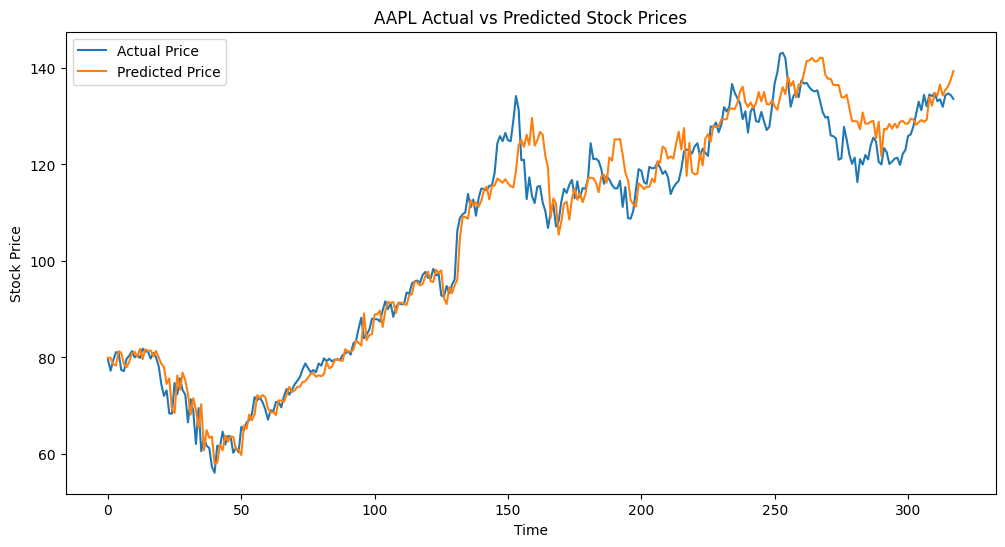

 
Mean Absolute Error - MAE : 3.7619434054054883
Root Mean Squared Error - RMSE : 5.0661327165140015


In [13]:
# visualize actual vs predicted test price

plt.figure(figsize=(12, 6))
plt.plot(original_ytest, label='Actual Price')
plt.plot(test_predict, label='Predicted Price')
plt.title('AAPL Actual vs Predicted Stock Prices')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

print(' ')
print("Mean Absolute Error - MAE : " + mae)
print("Root Mean Squared Error - RMSE : " + rmse)